In [164]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix

##### Hikari2021 Network Intrusion Dataset:
This dataset was extracted from Zenodo https://zenodo.org/records/6463389 by Andrey Ferriyan, et al.
We take this dataset to perform anomaly detection by conducting data augmentation on malicious DDoS attack samples to identify patterns that deviate from regular network traffic.

In [165]:
df = pd.read_csv('./hikari2022_dataset.csv')
df

,Unnamed: 0,uid,originh,originp,responh,responp,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,...,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,bwd_last_window_size,attack_category,Label
0,0,Cmu9v81jToQyRF1gbk,184.0.48.168,38164,184.0.48.150,50443,0 days 00:00:00.000060,1,1,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,64240,0,64240,0,Benign,0
1,1,CO21hl3TWkuXTOgajk,184.0.48.169,43068,184.0.48.150,50443,0 days 00:00:00.000083,1,1,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,64240,0,64240,0,Benign,0
2,2,CBLJ6L19FP0MfYX7Oh,184.0.48.124,5678,255.255.255.255,5678,0 days 00:01:59.996602,3,0,3,...,5.999912e+07,1.199966e+08,5.999830e+07,1156.846698,0,0,0,0,Benign,0
3,3,ChTG451zJ7hUYOcqje,184.0.48.124,5678,255.255.255.255,5678,0 days 00:00:59.996909,2,0,2,...,5.999691e+07,5.999691e+07,5.999691e+07,0.000000,0,0,0,0,Benign,0
4,4,Cn9y6E2KVxzQbs5wjc,184.0.48.124,5678,255.255.255.255,5678,0 days 00:00:59.992130,2,0,2,...,5.999213e+07,5.999213e+07,5.999213e+07,0.000000,0,0,0,0,Benign,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228248,16634,Clt16PPxzrXEtpa5d,184.0.48.20,53866,184.0.48.255,1947,0 days 00:00:00.000027,2,0,2,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,0,XMRIGCC CryptoMiner,1
228249,53170,Cs8RA72uHDiQa5ch2k,184.0.48.20,54318,184.0.48.255,1947,0 days 00:00:00.000027,2,0,2,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,0,XMRIGCC CryptoMiner,1
228250,53529,Cy4dqo4YEq5YGxjUXa,184.0.48.20,65355,184.0.48.255,1947,0 days 00:00:00,2,0,2,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,0,XMRIGCC CryptoMiner,1
228251,86308,CFXfNV3OTG04e0UnP4,184.0.48.20,53642,184.0.48.255,1947,0 days 00:00:00.000054,2,0,2,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,0,XMRIGCC CryptoMiner,1


### Data Pre-Processing

In [166]:
df['attack_category'].value_counts()

Benign                 214904
XMRIGCC CryptoMiner      7595
Bruteforce-XML           3650
Bruteforce               2104
Name: attack_category, dtype: int64

In [167]:
sum(df['attack_category'] != 'Benign')

13349

In [168]:
# 0 represents benign, 1 represents attack
df['Label'].value_counts()

0    214904
1     13349
Name: Label, dtype: int64

In [169]:
# proportion of benign and attack cases
df['Label'].value_counts() / len(df)

0    0.941517
1    0.058483
Name: Label, dtype: float64

Approximately 94.15% of the dataset is Benign while 5.84% is Attack cases, which is usually the case for an anomaly detection problem.

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228253 entries, 0 to 228252
Data columns (total 88 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                228253 non-null  int64  
 1   uid                       228253 non-null  object 
 2   originh                   228253 non-null  object 
 3   originp                   228253 non-null  int64  
 4   responh                   228253 non-null  object 
 5   responp                   228253 non-null  int64  
 6   flow_duration             228253 non-null  object 
 7   fwd_pkts_tot              228253 non-null  int64  
 8   bwd_pkts_tot              228253 non-null  int64  
 9   fwd_data_pkts_tot         228253 non-null  int64  
 10  bwd_data_pkts_tot         228253 non-null  int64  
 11  fwd_pkts_per_sec          228253 non-null  float64
 12  bwd_pkts_per_sec          228253 non-null  float64
 13  flow_pkts_per_sec         228253 non-null  f

In [171]:
# we pre-process the dataset to include only relevant samples and features

from sklearn.model_selection import train_test_split

# Define the size of the sample you want to take, for example, 10% of your data
sample_size = 0.7  # 70% of the full dataset

# Perform stratified sampling to maintain the proportion between classes
df_sampled, _ = train_test_split(
    df,
    test_size=1-sample_size,
    stratify=df['Label'],
    random_state=42  # for reproducibility
)

# the proportion of benign and attack cases is maintained
df_sampled['Label'].value_counts() / len(df_sampled), df_sampled.shape

(0    0.941518
 1    0.058482
 Name: Label, dtype: float64,
 (159777, 88))

In [172]:
df.columns

Index(['Unnamed: 0', 'uid', 'originh', 'originp', 'responh', 'responp',
       'flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot',
       'bwd_data_pkts_tot', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec',
       'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_tot',
       'fwd_header_size_min', 'fwd_header_size_max', 'bwd_header_size_tot',
       'bwd_header_size_min', 'bwd_header_size_max', 'flow_FIN_flag_count',
       'flow_SYN_flag_count', 'flow_RST_flag_count', 'fwd_PSH_flag_count',
       'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_URG_flag_count',
       'bwd_URG_flag_count', 'flow_CWR_flag_count', 'flow_ECE_flag_count',
       'fwd_pkts_payload.min', 'fwd_pkts_payload.max', 'fwd_pkts_payload.tot',
       'fwd_pkts_payload.avg', 'fwd_pkts_payload.std', 'bwd_pkts_payload.min',
       'bwd_pkts_payload.max', 'bwd_pkts_payload.tot', 'bwd_pkts_payload.avg',
       'bwd_pkts_payload.std', 'flow_pkts_payload.min',
       'flow_pkts_payload.max', 'flow_pkts_pay

In [173]:
# extract only relevant features
relevant_columns = [
    'fwd_pkts_tot', 'bwd_pkts_tot',
    'fwd_data_pkts_tot', 'bwd_data_pkts_tot', 'fwd_pkts_per_sec',
    'bwd_pkts_per_sec', 'flow_pkts_per_sec', 'down_up_ratio',
    'fwd_header_size_tot', 'bwd_header_size_tot',
    'fwd_pkts_payload.min', 'fwd_pkts_payload.max',
    'fwd_pkts_payload.tot', 'bwd_pkts_payload.min', 'bwd_pkts_payload.max',
    'bwd_pkts_payload.tot', 'flow_pkts_payload.min', 'flow_pkts_payload.max',
    'flow_pkts_payload.tot', 'fwd_iat.min', 'fwd_iat.max', 'fwd_iat.tot',
    'bwd_iat.min', 'bwd_iat.max', 'bwd_iat.tot', 'flow_iat.min', 'flow_iat.max',
    'flow_iat.tot', 'payload_bytes_per_second', 'fwd_subflow_pkts',
    'bwd_subflow_pkts', 'fwd_subflow_bytes', 'bwd_subflow_bytes',
    'fwd_bulk_bytes', 'bwd_bulk_bytes', 'fwd_bulk_packets', 'bwd_bulk_packets',
    'fwd_bulk_rate', 'bwd_bulk_rate', 'active.min', 'active.max', 'active.tot',
    'idle.min', 'idle.max', 'idle.tot', 'fwd_init_window_size', 'bwd_init_window_size',
    'fwd_last_window_size', 'bwd_last_window_size', 'Label'
]

# Select only the relevant columns for anomaly detection
df = df[relevant_columns]
df.dropna(inplace=True)
df.shape

/var/folders/yg/38mxj49129v4zj9l3h2zs9s40000gn/T/ipykernel_66312/2730267326.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


(228253, 50)

<AxesSubplot:>

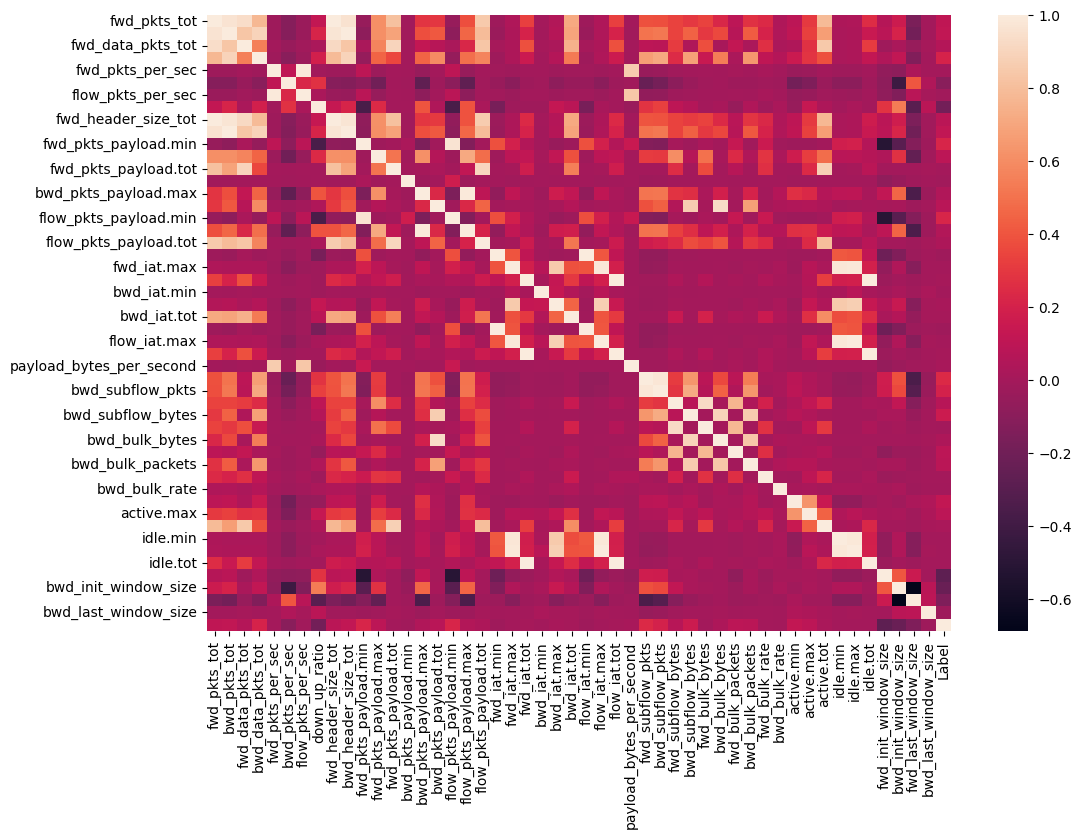

In [174]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr()) # Heatmap of correlation across columns.

Based on the color scale, the lighter colors indicate positive correlation, while darker colors indicate negative correlation. For example, we see that the features 'fwd_pkts_tot' and 'fwd_data_pkts_tot' have a positive correlation, which makes sense because the total number of packets sent should be equal to the total number of data packets sent plus the total number of control packets sent. On the contrary, 'fwd_pkts_per_sec' has a negative correlation with 'fwd_pkts_payload' as indicated by the dark purple cell. This makes sense given that the bigger the packet payload, the larger the packet size, which reduces latency since the packet takes a longer time to be transferred across the network. The diagonal axis of light cream colored cells typically represent the correlation of each feature with itself. It provides a reference point for interpreting off-diagonal cells. If the color of those cells are the same as the diagonal color, then those features are as strongly correlated with each other as they are with themselves, suggesting a very strong positive correlation. For instance, 'fwd_iat_max' has a strong correlation with idle times. As such, this correlation diagram suggests which features are highly correlated with each other. It's typical in anomaly detection to remove features that are highly correlated with each other to reduce the dimensionality of the dataset. However, in our case, the features have a weak correlation as the cells are mostly magenta-colored. So we will leave the dataset as is.

In [175]:
len(df.columns)

50

/var/folders/yg/38mxj49129v4zj9l3h2zs9s40000gn/T/ipykernel_66312/2711841843.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col][df['Label']==0],color='g',label='Benign Case')
/var/folders/yg/38mxj49129v4zj9l3h2zs9s40000gn/T/ipykernel_66312/2711841843.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

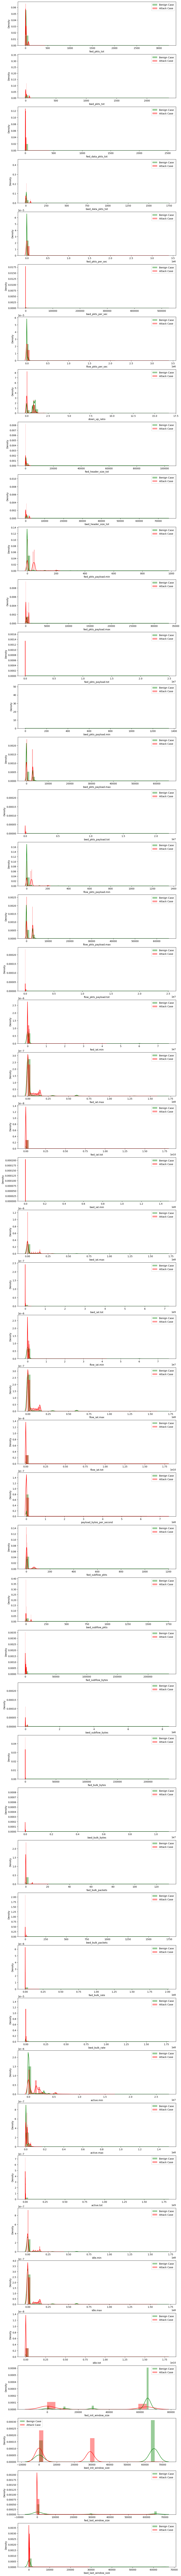

In [176]:
import matplotlib.gridspec as gridspec

# now that we have the heatmap to visualize feature correlation, we create a data visualization
# of the distribution of Benign cases & Attack cases for each feature
v_features = df.columns[:-1] # take out label column
plt.figure(figsize=(12,49*4))
gs = gridspec.GridSpec(49, 1)

for i, col in enumerate(v_features):
    ax = plt.subplot(gs[i])
    sns.distplot(df[col][df['Label']==0],color='g',label='Benign Case')
    sns.distplot(df[col][df['Label']==1],color='r',label='Attack Case')
    ax.legend()
plt.show()

Based on the above distribution plots, we can see that the distributions of the features between benign and attack cases have significant overlap for the majority. 
However, there are some features that have a clear distinction between benign and attack cases such as
'window_size'. In most cases, the distributions are not distinct enough to be able to clearly distinguish between benign and attack cases, 
though attack cases seem to have a higher density (higher peak) in general.

### Looking at the appropriate metrics
Our goal in anomaly detection is to maximize Precision and Recall value when setting attack cases positive. As benign cases are predominant in the dataset, accuracy is not so informative, since predicting all samples to be "normal" would still give us high accuracy (i.e. there is a high baseline).
 
In network intrusion detection problems, a False Negative is much more costly than False Positives because predicting an attack to be normal is more dangerous than predicting a normal case as malicious. But we still don't want our algorithm to have too many False Positives and predict too many benign cases to be network intrusions. Thus, we focus on improving recall.

### Selecting a model

We will perform anomaly detection using the following models:
1. Logistic Regression
2. Isolation Forest

In [177]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

X = df.drop('Label', axis=1)
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% training and 20% test

# 1. Logistic Regression
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)
ypred_lr = log_reg.predict(X_test)

# Evaluating Logistic Regression
print("Logistic Regression")
print("Accuracy: %.3f"%(accuracy_score(y_test, ypred_lr)))
print(classification_report(y_test, ypred_lr))

# ------------------------------------------------------------
# 2. Isolation Forest
iso_forest = IsolationForest(random_state=42, n_jobs=-1)
# As Isolation Forest is an unsupervised algorithm, we do not use y_train for fitting
iso_forest.fit(X_train)
# Predict anomalies on the test set (it returns -1 for outliers and 1 for inliers)
ypred_iso = iso_forest.predict(X_test)
# Convert the prediction to match the labeling convention of your dataset (0 for normal, 1 for anomaly)
ypred_test_iso = [0 if x == 1 else 1 for x in ypred_iso]

# Evaluating Isolation Forest
print("Isolation Forest")
print("Accuracy:", accuracy_score(y_test, ypred_test_iso))
print(classification_report(y_test, ypred_test_iso))

/Users/emilybae/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Accuracy: 0.920
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     42974
           1       0.33      0.35      0.34      2677

    accuracy                           0.92     45651
   macro avg       0.64      0.65      0.65     45651
weighted avg       0.92      0.92      0.92     45651

Isolation Forest
Accuracy: 0.9078662022737728
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     42974
           1       0.24      0.26      0.25      2677

    accuracy                           0.91     45651
   macro avg       0.60      0.60      0.60     45651
weighted avg       0.91      0.91      0.91     45651



Text(646.8585858585858, 0.5, 'True Label')

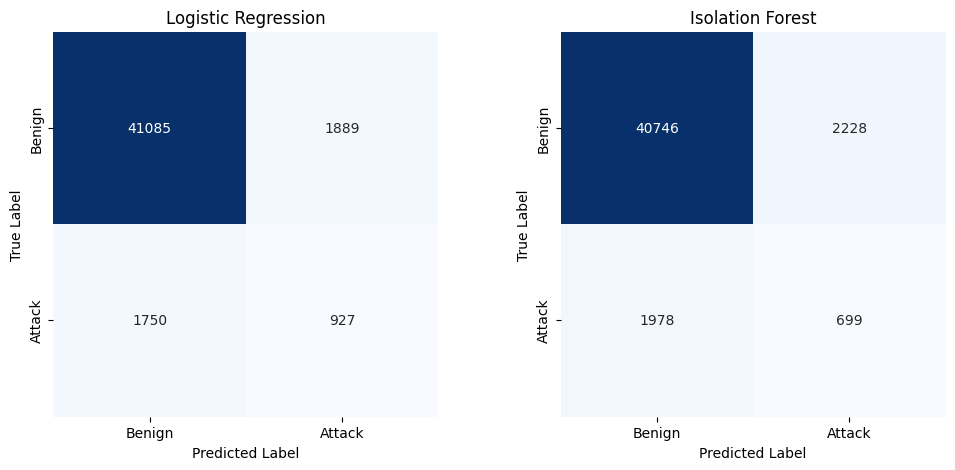

In [178]:
# Build confusion matrix
confusion_log = confusion_matrix(y_test, ypred_lr)
confusion_iso = confusion_matrix(y_test, ypred_test_iso)
lbl = ["Benign", "Attack"]

# Plot confusion matrix
plt.figure(figsize=(12, 5))
# for logistic regression
plt.subplot(1, 2, 1)
sns.heatmap(confusion_log, square=True, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=lbl, yticklabels=lbl)
plt.title('Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
# for isolation forest
plt.subplot(1, 2, 2)
sns.heatmap(confusion_iso, square=True, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=lbl, yticklabels=lbl)
plt.title('Isolation Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

### Interpretation of Plot

The first plot shows that Logistic Regression has more true positives and fewer false negatives than Isolation Forest.
This means that Logistic Regression is more likely to correctly classify attack cases.
This is ideal for our case, as we want to minimize the number of false negatives and capture as many attack cases as possible.
Although Logistic Regression has a greater number of false positives, mistaking benign cases for attacks, this is less of a concern in our case, as
our objective is to detect anomalies. The second plot shows that Isolation Forest has more false negatives and fewer false positives,
indicating that it is less sensitive in detecting attacks, but more conservative in classifying malicious attacks.
This presents a problem, as in anomaly detection, we would rather misclassify benign cases as attacks than the opposite direction.

Moreover, Logistic Regression has a higher accuracy score, precision, recall, and f1-score.
Therefore, we will use Logistic Regression as our anomaly detection model.

## Data Augmentation
We now experiment on different data augmentation methods to test if they can improve the performance of the Logistic Regression model.

There are two primary techniques we employ:
1. SMOTE Oversampling (Synthetic Minority Over-sampling Technique)
2. Random Oversampling

#### 1. SMOTE Oversampling:

Generating synthetic data of minority class (attack cases) to prevent overfitting.

1. For each sample in the minority class, the algorithm computes the k-nearest neighbors.
2. Depending on the amount of over-sampling needed, one or more of the k-nearest neighbors are chosen to create the synthetic samples.
3. A synthetic sample is created by choosing one of the k-nearest neighbors and computing a linear combination of the feature vectors of the minority class sample and its chosen neighbor.

SMOTE helps overcome overfitting problems posed by random over-sampling, as it generates new, synthetic training samples that are plausible rather than simply copying existing ones.
It is especially useful in anomaly detection cases where the class of interest (i.e. malicious network intrusions) is underrepresented in the available training data.
Using SMOTE, we now have a more balanced dataset, which can help improve the performance of the classification algorithm.

In [179]:
# label distribution of y_train before SMOTE
y_train.value_counts()

0    171930
1     10672
Name: Label, dtype: int64

In [180]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train, y_train)

y_smote.value_counts()

0    171930
1    171930
Name: Label, dtype: int64

As you can see, the number of malicious attack cases has increased from 7487 to 120334 by data augmenting using the SMOTE oversampling technique. We now fit the resampled data in our logistic regression model again, observing differences.

In [181]:
log_reg.fit(X_smote, y_smote)
ypred_smote = log_reg.predict(X_test)
classification_report(y_test, ypred_smote)

/Users/emilybae/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'              precision    recall  f1-score   support\n\n           0       1.00      0.92      0.96     42974\n           1       0.45      0.99      0.61      2677\n\n    accuracy                           0.93     45651\n   macro avg       0.72      0.95      0.79     45651\nweighted avg       0.97      0.93      0.94     45651\n'

We plot the confusion matrix again as we did before, but now on the SMOTE resampled data.

Text(113.9222222222222, 0.5, 'True Label')

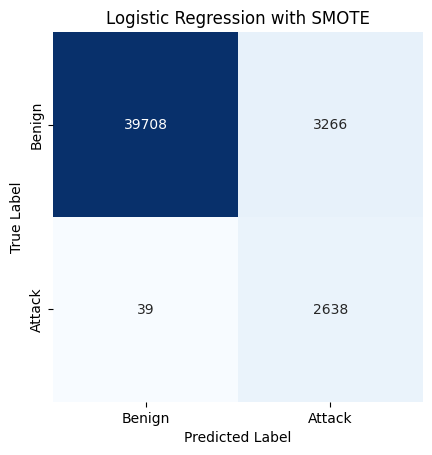

In [182]:
confusion_smote = confusion_matrix(y_test, ypred_smote)

sns.heatmap(confusion_smote, square=True, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=lbl, yticklabels=lbl)
plt.title('Logistic Regression with SMOTE')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

We compare this matrix with the previous logistic regression confusion matrix

Text(113.9222222222222, 0.5, 'True Label')

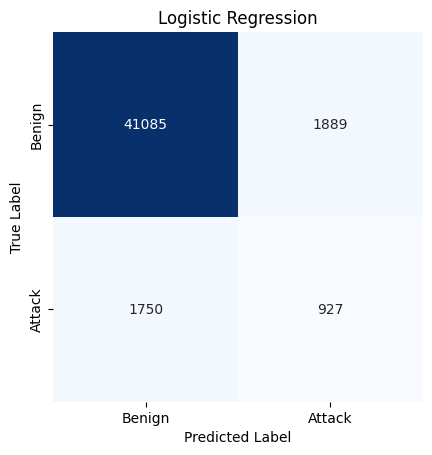

In [183]:
sns.heatmap(confusion_log, square=True, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=lbl, yticklabels=lbl)
plt.title('Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

#### Before vs. After SMOTE Oversampling 

##### Before
* True Positives (TP): 656 - The number of attack cases correctly identified as attacks.
* True Negatives (TN): 28802 - The number of benign cases correctly identified as benign.
* False Positives (FP): 1297 - The number of benign cases incorrectly identified as attacks.
* False Negatives (FN): 1201 - The number of attack cases incorrectly identified as benign.

##### After
* True Positives (TP): 1598 - The number of attack cases correctly identified as attacks.
* True Negatives (TN): 27919 - The number of benign cases correctly identified as benign.
* False Positives (FP): 2180 - The number of benign cases incorrectly identified as attacks.
* False Negatives (FN): 259 - The number of attack cases incorrectly identified as benign.

This matrix suggests that after using SMOTE to augment the data, the logistic regression model has become more sensitive to the attack class, correctly identifying a higher number of attacks (TP), but at the cost of incorrectly labeling more benign cases as attacks (FP). We are more concerned with correctly identifying attack cases, so our model performance has improved.

#### 2. Random Oversampling:

Random oversampling is a technique used to balance class distribution in a dataset with imbalanced classes. Specifically, it involves randomly replicating instances from the minority class to increase its representation. This method can help improve the performance of classification algorithms by providing a more balanced class distribution.

In [184]:
from imblearn.over_sampling import RandomOverSampler

# Define the resampling strategy
ros = RandomOverSampler(random_state=42)

# Resample the dataset
X_ros, y_ros = ros.fit_resample(X_train, y_train)

y_ros.value_counts()

0    171930
1    171930
Name: Label, dtype: int64

In [185]:
log_reg.fit(X_ros, y_ros)
ypred_ros = log_reg.predict(X_test)
classification_report(y_test, ypred_ros)

/Users/emilybae/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


'              precision    recall  f1-score   support\n\n           0       0.99      0.92      0.95     42974\n           1       0.40      0.85      0.54      2677\n\n    accuracy                           0.92     45651\n   macro avg       0.69      0.88      0.75     45651\nweighted avg       0.96      0.92      0.93     45651\n'

Text(113.9222222222222, 0.5, 'True Label')

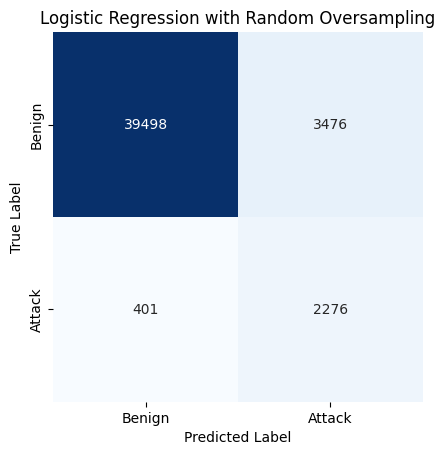

In [186]:
confusion_ros = confusion_matrix(y_test, ypred_ros)

sns.heatmap(confusion_ros, square=True, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=lbl, yticklabels=lbl)
plt.title('Logistic Regression with Random Oversampling')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

Again, we compare this matrix with the previous logistic regression confusion matrix

#### Before vs. After Random Oversampling 

##### Before
* True Positives (TP): 656 - The number of attack cases correctly identified as attacks.
* True Negatives (TN): 28802 - The number of benign cases correctly identified as benign.
* False Positives (FP): 1297 - The number of benign cases incorrectly identified as attacks.
* False Negatives (FN): 1201 - The number of attack cases incorrectly identified as benign.

##### After
* True Positives (TP): 1822 - The number of attack cases correctly predicted as attacks.
* True Negatives (TN): 27783 - The number of benign cases correctly predicted as benign.
* False Positives (FP): 2316 - The number of benign cases incorrectly predicted as attacks.
* False Negatives (FN): 35 - The number of attack cases incorrectly predicted as benign.

As shown, Random Oversampling results in a much higher number of True Positives, which means it is better at detecting attacks than the model without oversampling.
It also shows a lower number of False Negatives, indicating fewer missed attacks. However, the augmented model also has more False Positives, which means it incorrectly labels more benign cases as attacks. The non-augmented model is more conservative in predicting attacks, resulting in fewer False Positives but also missing more actual attacks (higher False Negatives).
As such, we again observe that our model performance has improved since we care more about identifying attack cases correctly.

### Conclusion

Based on the comparisons we made above, we can conclude that in the field of anomaly detection for identifying malicious network intrusions, both Random Oversampling and SMOTE are valuable techniques for addressing class imbalance between benign cases and attack cases. This is a common challenge in anomaly detection problems where the number of normal instances far exceeds the anomalous ones. Through Random Oversampling, we can increase the representation of the minority class by duplicating existing samples, which can lead to a more balanced dataset and thus enhance the sensitivity of anomaly detection models. However, this may also cause overfitting due to the mere replication of instances. On the other hand, if we employ the SMOTE data augmentation technique, we can generate new synthetic minority class samples by interpolating between existing ones, which introduces more diversity and helps in creating a more generalized model that is robust against overfitting to the minority class. While both methods improve the detection rates of malicious activities by providing more examples for the model to learn from, SMOTE's ability to generate new, yet reasonable samples offers a more effective and nuanced approach to improving classification performance in the context of network security.